<a href="https://colab.research.google.com/github/hyojunyee/kita_2404/blob/main/m5_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/ML_%EB%B6%84%EB%A5%983_%ED%94%BC%EB%A7%88%EC%9D%B8%EB%94%94%EC%96%B8%EB%8B%B9%EB%87%A8%EB%B3%91%EC%98%88%EC%B8%A1_0726.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q. diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']는 0값을 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압),
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

피마 인디언 당뇨병 데이터 셋은 아래와 같은 피처로 구성되어 있습니다.

*   Pregnancies : 임신횟수
*   Glucose : 포도당 부하 검사 수치
*   BloodPressure : 혈압
*   SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
*   Insulin : 혈청 인슐린
*   BMI : 체질량 지수
*   DiabetesPedigreeFunction : 당뇨 내력 가중치 값
*   Age : 나이
*   Outcome : 당뇨여부(0 또는 1)

In [4]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

diabetes_data = pd.read_csv('/content/drive/MyDrive/kdt_240424/m5_머신러닝/dataset/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [5]:
diabetes_data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
import numpy as np


print('Pregnancies', (diabetes_data['Pregnancies'].values == 0).sum())
print('Glucose', (diabetes_data['Glucose'].values == 0).sum())
print('BloodPressure', (diabetes_data['BloodPressure'].values == 0).sum())
print('SkinThickness', (diabetes_data['SkinThickness'].values == 0).sum())
print('Insulin', (diabetes_data['Insulin'].values == 0).sum())
print('BMI', (diabetes_data['BMI'].values == 0).sum())
print('DiabetesPedigreeFunction', (diabetes_data['DiabetesPedigreeFunction'].values == 0).sum())
print('Age', (diabetes_data['Age'].values == 0).sum())

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0


In [7]:
import pandas as pd
import numpy as np

# 데이터프레임 복사
dt = diabetes_data.copy()

# 각 열에서 0인 값을 그 열의 평균값으로 대체
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    mean_value = dt[column].replace(0, np.nan).mean()
    dt[column] = dt[column].replace(0, mean_value)

In [8]:
# 체크
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    print(f'{column} : {(dt[column].values == 0).sum()}')

Glucose : 0
BloodPressure : 0
SkinThickness : 0
Insulin : 0
BMI : 0


#전처리 안함

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def eval(y_test, pred, pred_proba):
    print('정확도 : ', accuracy_score(y_test, pred))
    print('정밀도 : ', precision_score(y_test, pred))
    print('재현율 : ', recall_score(y_test, pred))
    print('F1 Score : ', f1_score(y_test, pred))
    print('ROC_AUC Score : ', roc_auc_score(y_test, pred_proba))
    print('Confusion Matrix : \n', confusion_matrix(y_test, pred))
    print()

# 타겟 변수와 피처 변수 설정
X = dt.drop('Outcome', axis=1)
y = dt['Outcome']

scalar = StandardScaler()
X = scalar.fit_transform(X)

# stratify는 훈련/테스트 데이터들이 원래의 input dataset의 클래스의 비율과 같은 비율을 가지도록 할 것인지 지정한다
# 예를 들어 0.1의 클래스가 input dataset에 20:80 비율로 있었다면 훈련 데이터와 테스트 데이터 역시 각각의 클래스가 같은 비율로 있도록 지정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=156, stratify=y)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:,1]

eval(y_test, pred, pred_proba)

정확도 :  0.8008658008658008
정밀도 :  0.7536231884057971
재현율 :  0.6419753086419753
F1 Score :  0.6933333333333332
ROC_AUC Score :  0.8422222222222222
Confusion Matrix : 
 [[133  17]
 [ 29  52]]



In [10]:
#
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


thresholds = [0.3,  0.31, 0.32, 0.33, 0.34, 0.35,
              0.36, 0.37, 0.38, 0.39, 0.4,
              0.41, 0.42, 0.43, 0.44, 0.45,
              0.46, 0.47, 0.48, 0.49, 0.5,
              0.51, 0.52, 0.53, 0.54, 0.55,]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # threshold list객체내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold)
        custom_predict = binarizer.fit_transform(pred_proba_c1)
        print('임곗값 ', custom_threshold)

        eval(y_test, custom_predict, pred_proba)
        print()

def eval(y_test, pred, pred_proba):
    print('정확도 : ', accuracy_score(y_test, pred))
    print('정밀도 : ', precision_score(y_test, pred))
    print('재현율 : ', recall_score(y_test, pred))
    print('F1 Score : ', f1_score(y_test, pred))
    print('ROC_AUC Score : ', roc_auc_score(y_test, pred_proba))
    print('Confusion Matrix : \n', confusion_matrix(y_test, pred))
    print()

# 타겟 변수와 피처 변수 설정
X = dt.drop('Outcome', axis=1)
y = dt['Outcome']

scalar = StandardScaler()
X = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=156, stratify=y)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test

lr = LogisticRegression(max_iter=500, solver='lbfgs', random_state=156)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:,1]

get_eval_by_threshold(y_test, pred_proba.reshape(-1, 1), thresholds)

임곗값  0.3
정확도 :  0.7575757575757576
정밀도 :  0.616822429906542
재현율 :  0.8148148148148148
F1 Score :  0.702127659574468
ROC_AUC Score :  0.8422222222222222
Confusion Matrix : 
 [[109  41]
 [ 15  66]]


임곗값  0.31
정확도 :  0.7575757575757576
정밀도 :  0.6190476190476191
재현율 :  0.8024691358024691
F1 Score :  0.6989247311827957
ROC_AUC Score :  0.8422222222222222
Confusion Matrix : 
 [[110  40]
 [ 16  65]]


임곗값  0.32
정확도 :  0.7619047619047619
정밀도 :  0.625
재현율 :  0.8024691358024691
F1 Score :  0.7027027027027027
ROC_AUC Score :  0.8422222222222222
Confusion Matrix : 
 [[111  39]
 [ 16  65]]


임곗값  0.33
정확도 :  0.7705627705627706
정밀도 :  0.6428571428571429
재현율 :  0.7777777777777778
F1 Score :  0.7039106145251396
ROC_AUC Score :  0.8422222222222222
Confusion Matrix : 
 [[115  35]
 [ 18  63]]


임곗값  0.34
정확도 :  0.7792207792207793
정밀도 :  0.6630434782608695
재현율 :  0.7530864197530864
F1 Score :  0.7052023121387283
ROC_AUC Score :  0.8422222222222222
Confusion Matrix : 
 [[119  31]
 [ 20  61]]


임곗값  0.35
정

[0.015034048164179081, 0.01640223795959228, 0.01662832611999052, 0.021522419111785537, 0.023937985410364574, 0.026170712722826034, 0.03310501940139208, 0.03350643392158397, 0.03512590763020667, 0.03645040898790504, 0.03758887966958794, 0.037691422603675646, 0.037973149905042795, 0.03934216183808916, 0.039735174294520115, 0.04309910428936032, 0.04449340806722186, 0.04995042137714104, 0.050546537254904364, 0.05346333155781888, 0.053952360867092417, 0.055683848410625986, 0.05682009387839821, 0.05685800256649032, 0.05820347562594841, 0.05846678823772429, 0.059402940096769, 0.05982311380923319, 0.059829633815920845, 0.060144733314432326, 0.06261872238975964, 0.0639642899532863, 0.06524793637245853, 0.0668060770372567, 0.07023614331530395, 0.0706851679980083, 0.07539892635582635, 0.08280126035591605, 0.08566231140675257, 0.08615734113652197, 0.08987413513432653, 0.0904944109427691, 0.09466311822524189, 0.09474087065852096, 0.09780821386012396, 0.09852958684335208, 0.09885660935445889, 0.0991

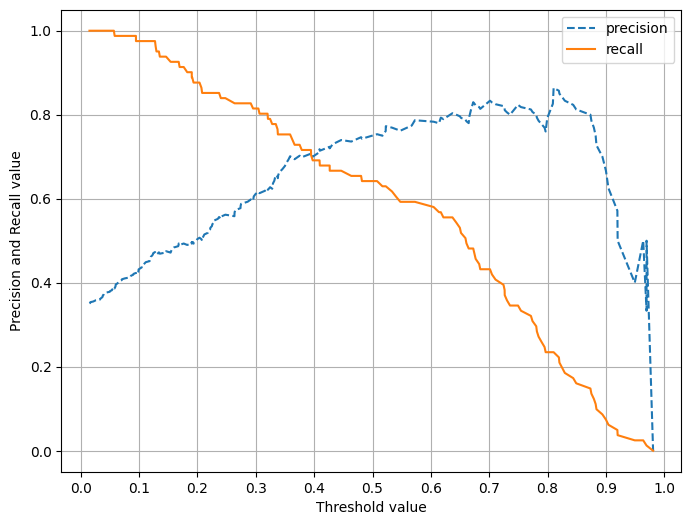

In [11]:
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba)
    print(list(thresholds))
    print(thresholds.shape)
    threshold_boundary = thresholds.shape[0]
    print(threshold_boundary)
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 직선으로 표시
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 x축의 Scale을 0.1단위로 변경
    start, end = plt.xlim() # 플롯의 x축의 현재 한계를 반환
    plt.xticks(np.round(np.arange(start, end, 0.1), 1))

    # x축, y축, label과 legend, 그리고 grid 설정
    plt.xlabel("Threshold value"); plt.ylabel("Precision and Recall value")
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr.predict_proba(X_test)[:,1])